In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
from torchvision import transforms
import numpy as np
import PIL.Image as Image
import utils_bigbigan as ubigbi
import glob

/afs/csail.mit.edu/u/j/jahanian/.conda/envs/stenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/afs/csail.mit.edu/u/j/jahanian/.conda/envs/stenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/afs/csail.mit.edu/u/j/jahanian/.conda/envs/stenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def convert_to_images(obj):
    """ Convert an output tensor from BigGAN in a list of images.
    """
    # need to fix import, see: https://github.com/huggingface/pytorch-pretrained-BigGAN/pull/14/commits/68a7446951f0b9400ebc7baf466ccc48cdf1b14c
    if not isinstance(obj, np.ndarray):
        obj = obj.detach().numpy()
    obj = obj.transpose((0, 2, 3, 1))
    obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    img = []
    for i, out in enumerate(obj):
        out_array = np.asarray(np.uint8(out), dtype=np.uint8)
        img.append(Image.fromarray(out_array))
    return img

class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]
    
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
normalize = transforms.Normalize(mean=mean, std=std)
img_size = 128
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=int(img_size*0.875), scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])
aug_SimCLR = TwoCropTransform(train_transform)


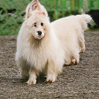

Anchor
Isotropic views


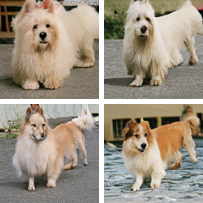

In [25]:
# anchor = Image.open('/data/vision/phillipi/ganclr/datasets/bigbigan_samples_paper_figure/train/n03930630/717_seed35976_sample5_anchor.png')
# anchor_list = glob.glob('/data/vision/phillipi/ganclr/datasets/bigbigan_samples_paper_figure/train/*/*anchor.png')
anchor_list = []
anchor_list.append('/data/vision/phillipi/ganclr/datasets/bigbigan_samples_paper_figure/train/n03530642/599_seed24890_sample8_anchor.png')

anchor_name = np.random.choice(anchor_list)
anchor_im = Image.open(anchor_name).resize((99,99))
ubigbi.imshow(np.array(anchor_im))
print('Anchor')
iso_view = []
for i in range(4):
    im = Image.open(anchor_name.replace('anchor', 'iso_{}'.format(i+1))).resize((99,99))
    iso_view.append(np.array(im))
print('Isotropic views')
ubigbi.imshow(ubigbi.imgrid(np.stack(iso_view), pad=5, cols=2))

simclr views


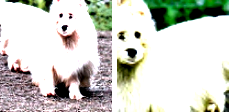

simclr views


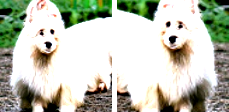

In [26]:
## simclr views
anchor_im = Image.open(anchor_name)

simclr_view = aug_SimCLR(anchor_im)
ims = []
for i in range(2):
    obj = simclr_view[i].numpy()
    obj = obj.transpose((1, 2, 0))
    obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    ims.append(obj)
print('simclr views')
ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))
# one more time...
simclr_view = aug_SimCLR(anchor_im)
ims = []
for i in range(2):
    obj = simclr_view[i].numpy()
    obj = obj.transpose((1, 2, 0))
    obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    ims.append(obj)
print('simclr views')
ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))

steer views


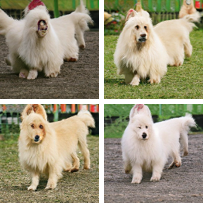

In [30]:
# indep views
indep_view = []
for i in range(4):
    im = Image.open(anchor_name.replace('anchor', 'steer_{}'.format(i+1))).resize((99,99))
    indep_view.append(np.array(im))
print('steer views')
ubigbi.imshow(ubigbi.imgrid(np.stack(indep_view), pad=5, cols=2))

Iso + simclr views


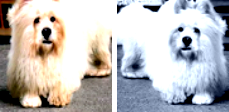

Iso + simclr views


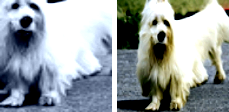

Iso + simclr views


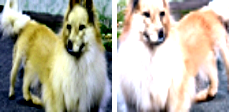

Iso + simclr views


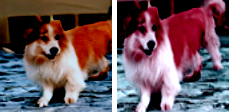

In [28]:
## Iso + simclr views  
for i in range(len(iso_view)):
    simclr_view = aug_SimCLR(Image.fromarray(iso_view[i]))
    ims = []
    for i in range(2):
        obj = simclr_view[i].numpy()
        obj = obj.transpose((1, 2, 0))
        obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    #     ubigbi.imshow(obj)
        ims.append(obj)
    print('Iso + simclr views')    
    ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))

Steer + simclr views


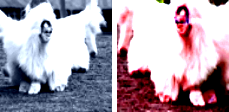

Steer + simclr views


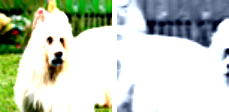

Steer + simclr views


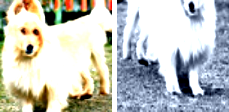

Steer + simclr views


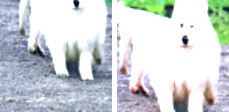

In [31]:
## Steer + simclr views  
for i in range(len(indep_view)):
    simclr_view = aug_SimCLR(Image.fromarray(indep_view[i]))
    ims = []
    for i in range(2):
        obj = simclr_view[i].numpy()
        obj = obj.transpose((1, 2, 0))
        obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    #     ubigbi.imshow(obj)
        ims.append(obj)
    print('Steer + simclr views')    
    ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))

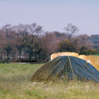

Anchor
Isotropic views


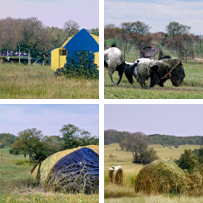

In [32]:
# anchor = Image.open('/data/vision/phillipi/ganclr/datasets/bigbigan_samples_paper_figure/train/n03930630/717_seed35976_sample5_anchor.png')
# anchor_list = glob.glob('/data/vision/phillipi/ganclr/datasets/bigbigan_samples_paper_figure/train/*/*anchor.png')
anchor_list =[]
anchor_list.append('/data/vision/phillipi/ganclr/datasets/bigbigan_samples_paper_figure/train/n03637318/619_seed44965_sample1_anchor.png')

anchor_name = np.random.choice(anchor_list)
anchor_im = Image.open(anchor_name).resize((99,99))
ubigbi.imshow(np.array(anchor_im))
print('Anchor')
iso_view = []
for i in range(4):
    im = Image.open(anchor_name.replace('anchor', 'iso_{}'.format(i+1))).resize((99,99))
    iso_view.append(np.array(im))
print('Isotropic views')
ubigbi.imshow(ubigbi.imgrid(np.stack(iso_view), pad=5, cols=2))

simclr views


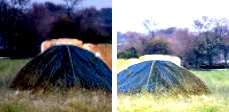

simclr views


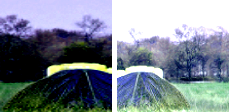

In [33]:
## simclr views
anchor_im = Image.open(anchor_name)

simclr_view = aug_SimCLR(anchor_im)
ims = []
for i in range(2):
    obj = simclr_view[i].numpy()
    obj = obj.transpose((1, 2, 0))
    obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    ims.append(obj)
print('simclr views')
ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))
# one more time...
simclr_view = aug_SimCLR(anchor_im)
ims = []
for i in range(2):
    obj = simclr_view[i].numpy()
    obj = obj.transpose((1, 2, 0))
    obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    ims.append(obj)
print('simclr views')
ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))

Iso + simclr views


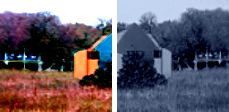

Iso + simclr views


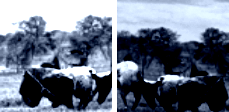

Iso + simclr views


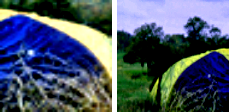

Iso + simclr views


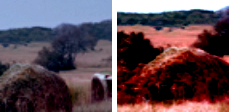

In [34]:
## Iso + simclr views  
for i in range(len(iso_view)):
    simclr_view = aug_SimCLR(Image.fromarray(iso_view[i]))
    ims = []
    for i in range(2):
        obj = simclr_view[i].numpy()
        obj = obj.transpose((1, 2, 0))
        obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    #     ubigbi.imshow(obj)
        ims.append(obj)
    print('Iso + simclr views')    
    ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))

steer views


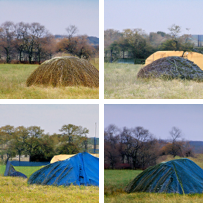

In [36]:
# indep views
indep_view = []
for i in range(4):
    im = Image.open(anchor_name.replace('anchor', 'steer_{}'.format(i+1))).resize((99,99))
    indep_view.append(np.array(im))
print('steer views')
ubigbi.imshow(ubigbi.imgrid(np.stack(indep_view), pad=5, cols=2))


Steer + simclr views


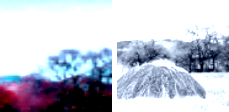

Steer + simclr views


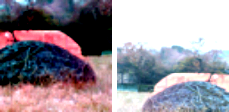

Steer + simclr views


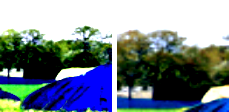

Steer + simclr views


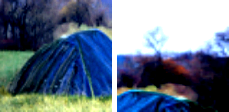

In [37]:
## Steer + simclr views  
for i in range(len(indep_view)):
    simclr_view = aug_SimCLR(Image.fromarray(indep_view[i]))
    ims = []
    for i in range(2):
        obj = simclr_view[i].numpy()
        obj = obj.transpose((1, 2, 0))
        obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    #     ubigbi.imshow(obj)
        ims.append(obj)
    print('Steer + simclr views')    
    ubigbi.imshow(ubigbi.imgrid(np.stack(ims), pad=5, cols=2))